In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from functools import reduce
import json
import tqdm
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect
import numpy as np
from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
import pickle

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
morph_ru = MorphAnalyzer(lang='ru')
morph_uk = MorphAnalyzer(lang='uk')
lemmatizer_en = WordNetLemmatizer()

def clear_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation + '«»—–-’'))
    return text.replace('\n', ' ')


def clear_emojis(text):
    emojis = []
    with open('data/emoji.txt', encoding='utf-8') as file:
        for line in file.readlines():
            emojis.append(line.strip())
    return text.translate(str.maketrans('', '', ''.join(emojis)))


def get_stopwords_remover(stop_words):
    return lambda words: [word for word in words if not word.lower() in stop_words]


def preprocessing_pipeline(steps):
    return lambda raw_text: reduce(lambda data, func: func(data), steps, raw_text)


def prepare_words(text):
    lang = detect(text)
    match lang:
        case 'en':
            full_lang = 'english'
        case _:
            full_lang = 'russian'

    words = word_tokenize(text, language=full_lang)

    match lang:
        case 'uk':
            return [morph_uk.parse(word)[0].normal_form for word in words]
        case 'en':
            return [lemmatizer_en.lemmatize(word) for word in words]
        case _:
            return [morph_ru.parse(word)[0].normal_form for word in words]

In [3]:
with open('data/advocat_prava.json', encoding='utf-8', errors='ignore') as json_file:
    json_data = json.load(json_file)
json_messages = json_data['messages']
messages = []
for message in tqdm.tqdm(json_messages[:1000]):
    text = message['text']
    l = []
    for entity in text:
        if isinstance(entity, str):
            l.append(entity)
        elif isinstance(entity, dict):
            l.append(entity['text'])
    l = [s for s in l if s]
    if l:
        messages.append(''.join(l))

messages = pd.DataFrame(messages, columns=['text'])
messages.iloc[:50]

100%|██████████| 1000/1000 [00:00<00:00, 329766.81it/s]


,text
0,⚡️ Международный аэропорт Харькова закрыт на п...
1,❗️Центр противодействия дезинформации сообщает...
2,❗️Украина запросила срочное заседание Совбеза ...
3,❗️Воздушное пространство Украины полностью зак...
4,❗️❗️Путин принял решение о специальной военной...
5,"""❗Мною принято решение о проведение специально..."
6,❗️Военная операция в Донбассе начинается — зая...
7,"‼️Вся линия фронта, очень громко. Бьют из Град..."
8,Видео запуска ракет с территории России
9,"Харьков, Мариуполь, Бердянск, Борисполь, Киев ..."


In [4]:
with open('data/stopwords_ua.txt', encoding='utf-8') as file:
    stopwords_ua = file.read().splitlines()

In [5]:
stop_words = set(stopwords.words('english') + stopwords.words('russian') + stopwords_ua)
remove_stopwords = get_stopwords_remover(stop_words)
stop_words

{'всяка',
 'е',
 'т',
 'ніякісінька',
 'позатої',
 'завжди',
 'ли',
 'this',
 'тепер',
 'всіма',
 'до',
 'усюди',
 'про',
 'ней',
 'декотрого',
 'обабіч',
 'в напрямі до',
 "mightn't",
 'and',
 'цюк',
 'в міру',
 'кожними',
 'такої',
 'всюди',
 'якоїсь',
 'вами',
 'якісь',
 'жодній',
 'ерг',
 'кожна',
 'хорошо',
 'може',
 'роб',
 'були',
 'три',
 'ще',
 'неабичого',
 'середи',
 'в бік',
 'нічийнім',
 'інакшому',
 'під',
 'оцими',
 'вашої',
 'я',
 'цор',
 'for',
 'кількома',
 'особливо',
 'якщо',
 'own',
 'всілякої',
 'еч',
 'за рахунок',
 'mightn',
 'здовж',
 'незважаючи на',
 'haven',
 'нікотре',
 'оподалік від',
 'тот',
 'важлива',
 'баш',
 'ourselves',
 'коштом',
 'мов',
 'отією',
 'абикого',
 'будет',
 'всякого',
 'йому',
 'off',
 'йол',
 'та',
 'нерідко',
 'ага',
 'неподалеку',
 'впритиск',
 'жоднісіньке',
 'звідкіля',
 'нами',
 'зсередини',
 'могли',
 'абикуди',
 'чому',
 'кого',
 "wasn't",
 'разу',
 'можеш',
 'ких',
 'аніякісінькому',
 'віг',
 'моїй',
 'жоднісінький',
 'отакою',

In [6]:
pipe = preprocessing_pipeline([
    clear_punctuation,
    clear_emojis,
    prepare_words,
    remove_stopwords
])

In [7]:
messages['words'] = messages.text.apply(pipe)
messages.iloc[:50]

,text,words
0,⚡️ Международный аэропорт Харькова закрыт на п...,"[международный, аэропорт, харьков, закрытый, п..."
1,❗️Центр противодействия дезинформации сообщает...,"[центр, противодействие, дезинформация, сообща..."
2,❗️Украина запросила срочное заседание Совбеза ...,"[украина, запросить, срочный, заседание, совбе..."
3,❗️Воздушное пространство Украины полностью зак...,"[воздушный, пространство, украина, полностью, ..."
4,❗️❗️Путин принял решение о специальной военной...,"[путин, принять, решение, специальный, военный..."
5,"""❗Мною принято решение о проведение специально...","[принять, решение, проведение, специальный, во..."
6,❗️Военная операция в Донбассе начинается — зая...,"[военный, операция, донбасс, начинаться, заявл..."
7,"‼️Вся линия фронта, очень громко. Бьют из Град...","[линия, фронт, очень, громко, бить, град, оста..."
8,Видео запуска ракет с территории России,"[видео, запуск, ракета, территория, россия]"
9,"Харьков, Мариуполь, Бердянск, Борисполь, Киев ...","[харьков, мариуполь, бердянск, борисполь, киев..."


In [8]:
advocat_prava_words = pd.Series(np.concatenate(messages.words))
advocat_prava_words.head()

0    международный
1         аэропорт
2          харьков
3         закрытый
4            приём
dtype: object

In [9]:
with open('data/lemmatized_words.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(advocat_prava_words))

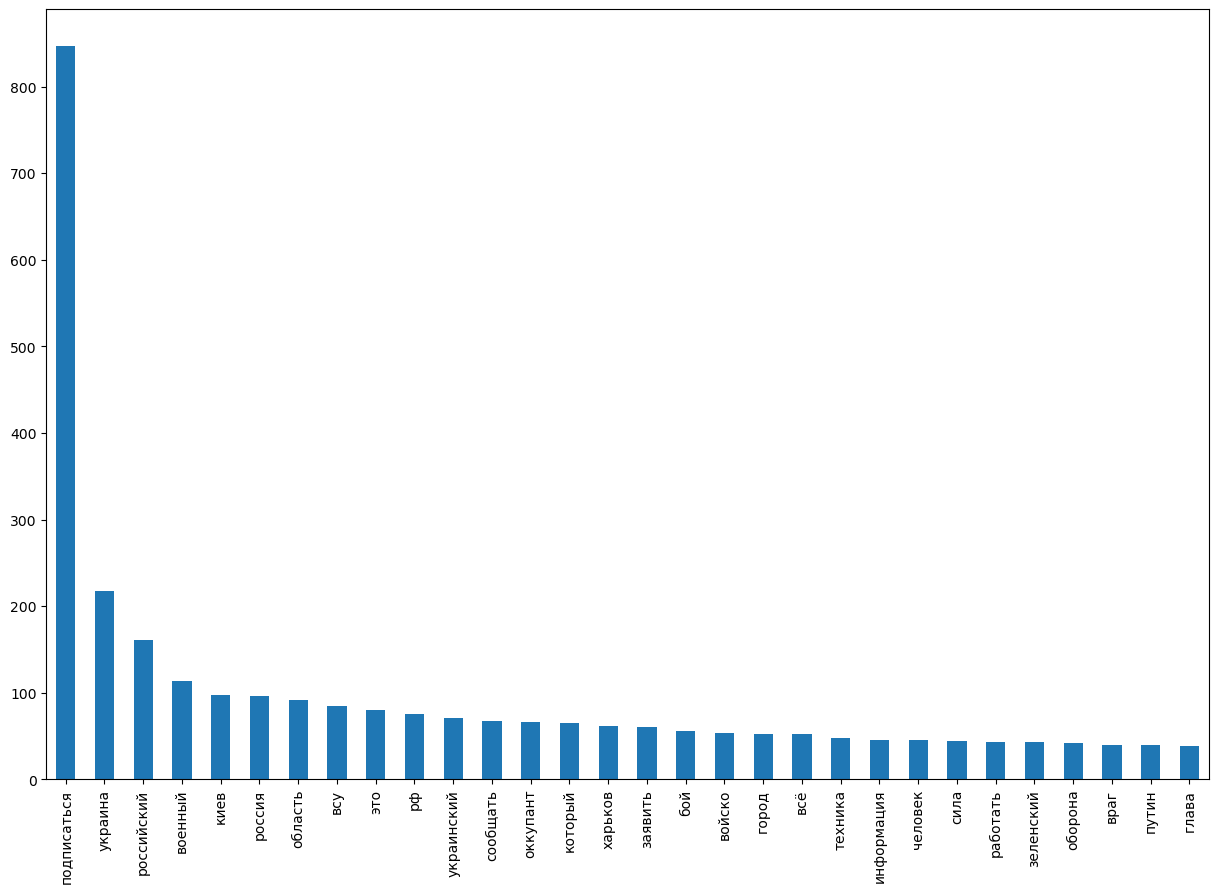

In [10]:
_, ax = plt.subplots(figsize=(15, 10))
advocat_prava_words.value_counts().head(30).plot.bar();

In [11]:
custom_stopwords = {'подписаться', 'это', 'всё'}
custom_stopwords_remover = get_stopwords_remover(custom_stopwords)
messages.words = messages.words.apply(custom_stopwords_remover)
advocat_prava_words = pd.Series(np.concatenate(messages.words))

In [12]:
wordcloud = WordCloud(
    background_color='white',
    width=800, height=800
)

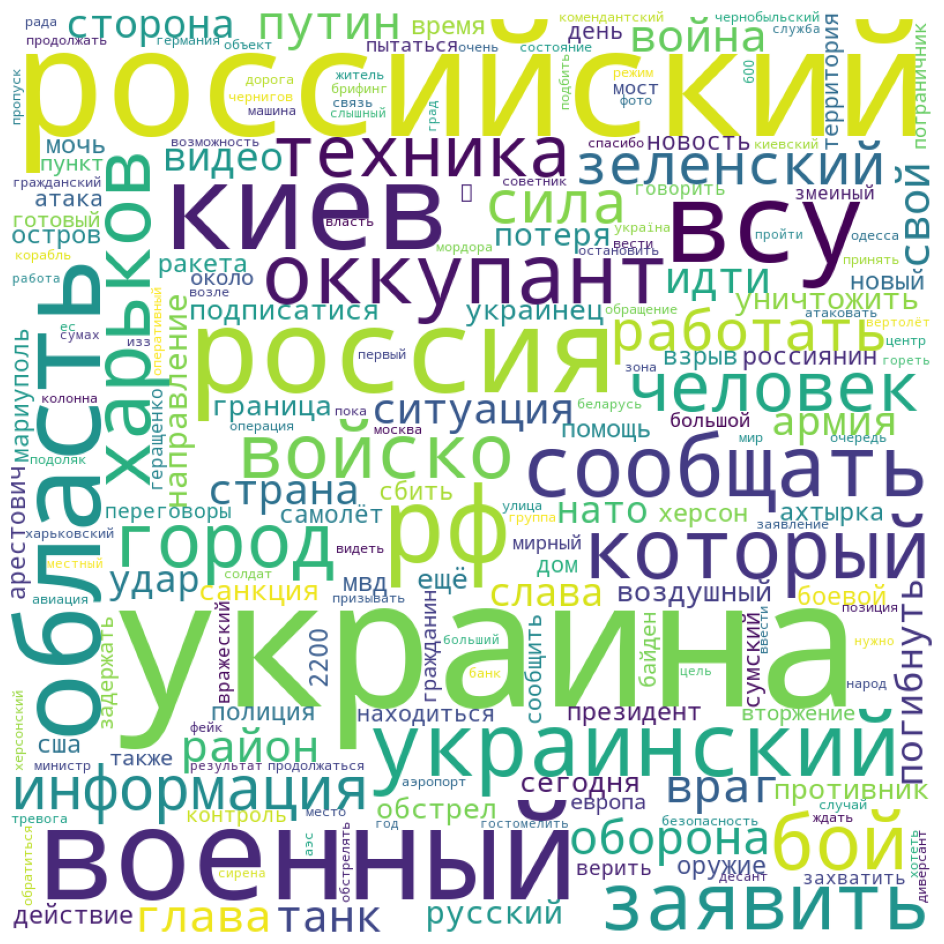

In [13]:
advocat_prava_cloud = wordcloud.generate_from_frequencies(advocat_prava_words.value_counts())

plt.figure(figsize=(12, 12))
plt.imshow(advocat_prava_cloud)
plt.axis(False);

In [14]:
messages['clean_text'] = messages.words.str.join(' ')
messages.head()

,text,words,clean_text
0,⚡️ Международный аэропорт Харькова закрыт на п...,"[международный, аэропорт, харьков, закрытый, п...",международный аэропорт харьков закрытый приём ...
1,❗️Центр противодействия дезинформации сообщает...,"[центр, противодействие, дезинформация, сообща...",центр противодействие дезинформация сообщать г...
2,❗️Украина запросила срочное заседание Совбеза ...,"[украина, запросить, срочный, заседание, совбе...",украина запросить срочный заседание совбез оон...
3,❗️Воздушное пространство Украины полностью зак...,"[воздушный, пространство, украина, полностью, ...",воздушный пространство украина полностью закры...
4,❗️❗️Путин принял решение о специальной военной...,"[путин, принять, решение, специальный, военный...",путин принять решение специальный военный опер...


In [15]:
vectorizer = CountVectorizer()
bag_of_words_matrix = vectorizer.fit_transform(messages.clean_text)

In [16]:
bag_of_words_matrix

<896x3596 sparse matrix of type '<class 'numpy.int64'>'
	with 11204 stored elements in Compressed Sparse Row format>

In [17]:
df_bow_sklearn = pd.DataFrame(bag_of_words_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df_bow_sklearn.head(10)

,000,0173,0200,0300,0600,0835,0836,0838,10,100,...,япония,ясно,яснопонятный,європа,єдиний,єпідтримка,інвалідність,інструкція,інформація,ініціатива
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
with open('data/bag_of_words_matrix.pkl', 'wb') as file:
    pickle.dump(bag_of_words_matrix, file)
with open('data/vocabulary.pkl', 'wb') as file:
    pickle.dump(vectorizer.vocabulary_, file)

In [19]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(messages.clean_text)

In [20]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [21]:
tf_idf_metrics = messages[['text']].copy(deep=True)
for word in advocat_prava_words.value_counts().head(10).index:
    tf_idf_metrics[word] = 0
    word_index = np.where(tfidf_feature_names == word)[0][0]
    for document_index, _ in tf_idf_metrics.iterrows():
        tf_idf_metrics.loc[document_index, word] = tfidf_matrix[document_index, word_index]
tf_idf_metrics

,text,украина,российский,военный,киев,россия,область,всу,рф,украинский,сообщать
0,⚡️ Международный аэропорт Харькова закрыт на п...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,❗️Центр противодействия дезинформации сообщает...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.111147,0.114904,0.112504
2,❗️Украина запросила срочное заседание Совбеза ...,0.111652,0.0,0.136250,0.000000,0.145240,0.0,0.0,0.000000,0.000000,0.000000
3,❗️Воздушное пространство Украины полностью зак...,0.165100,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,❗️❗️Путин принял решение о специальной военной...,0.000000,0.0,0.239624,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
891,"❗⚡️Audi, Jaguar Land Rover, BMW, Mercedes-Benz...",0.000000,0.0,0.000000,0.000000,0.133391,0.0,0.0,0.000000,0.000000,0.140245
892,❗️ В разных частях Киева сообщают о сильных вз...,0.000000,0.0,0.000000,0.183843,0.000000,0.0,0.0,0.000000,0.000000,0.198789
893,‼️Взрывы на Троещине в Киеве\n\nПОДПИСАТЬСЯ,0.000000,0.0,0.000000,0.393919,0.000000,0.0,0.0,0.000000,0.000000,0.000000
894,"❗🔥 Хорошо горит. Русские солдаты, не воюйте с ...",0.243636,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [22]:
tf_idf_metrics.iloc[5].text

'"❗Мною принято решение о проведение специальной военной операции".  - Путин.\n\nПутин выступает с экстренным обращением: \n\n✅Мы с уважением относимся ко всем вновь образованным после распада СССР странам. Пример тому — наша помощь Казахстану. \n\n✅Россия не может существовать с постоянной угрозой, исходящей с территории Украины.\n\n✅ Нам с вами не оставили ни одной возможности защитить наших людей, кроме той, которую мы используем сегодня. \n\n✅Народные республики Донбасса обратились к Россией с просьбой о помощи.\n\n✅ В наши планы не входит оккупация Украины\n\nПОДПИСАТЬСЯ'

In [23]:
messages

,text,words,clean_text
0,⚡️ Международный аэропорт Харькова закрыт на п...,"[международный, аэропорт, харьков, закрытый, п...",международный аэропорт харьков закрытый приём ...
1,❗️Центр противодействия дезинформации сообщает...,"[центр, противодействие, дезинформация, сообща...",центр противодействие дезинформация сообщать г...
2,❗️Украина запросила срочное заседание Совбеза ...,"[украина, запросить, срочный, заседание, совбе...",украина запросить срочный заседание совбез оон...
3,❗️Воздушное пространство Украины полностью зак...,"[воздушный, пространство, украина, полностью, ...",воздушный пространство украина полностью закры...
4,❗️❗️Путин принял решение о специальной военной...,"[путин, принять, решение, специальный, военный...",путин принять решение специальный военный опер...
...,...,...,...
891,"❗⚡️Audi, Jaguar Land Rover, BMW, Mercedes-Benz...","[audi, jaguar, land, rover, bmw, mercedesbenz,...",audi jaguar land rover bmw mercedesbenz citroe...
892,❗️ В разных частях Киева сообщают о сильных вз...,"[разный, часть, киев, сообщать, сильный, взрыв...",разный часть киев сообщать сильный взрыв включ...
893,‼️Взрывы на Троещине в Киеве\n\nПОДПИСАТЬСЯ,"[взрыв, троещиня, киев]",взрыв троещиня киев
894,"❗🔥 Хорошо горит. Русские солдаты, не воюйте с ...","[гореть, русский, солдат, воевать, украина, на...",гореть русский солдат воевать украина направит...
